## **REFERENCES**
#### Youtube tutorial: https://www.youtube.com/watch?v=htNmFL2BG34
#### Github repo: https://github.com/iamirmasoud/image_captioning




In [27]:
import math
from pycocotools.coco import COCO
from torchvision import transforms
from tqdm.notebook import tqdm
import torch.nn as nn
import torch
import torch.utils.data as data
from collections import defaultdict
import json
import os
import sys
import numpy as np
#from nlp_utils import clean_sentence, bleu_score

import os.path
import pickle
from collections import Counter

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from pycocotools.coco import COCO

import json
import os

import nltk
from PIL import Image
from pycocotools.coco import COCO
from torch.utils import data as data
from tqdm import tqdm

import torch.utils.data as data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## **This file has all the components together, i.e: Loading, preparing, Training, Validating & Testing.**

## **Step 1: Loading MSCOCO Dataset**

In [11]:
# Download training images (train2017.zip)
!wget http://images.cocodataset.org/zips/train2017.zip

# Unzip into a specific folder
!mkdir -p /content/cocoapi/images  # Create a folder for training images
!unzip -q train2017.zip -d /content/cocoapi/images  # Extract images

--2025-01-24 14:47:45--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.25.82, 52.217.165.153, 52.216.152.148, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.25.82|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  77.8MB/s    in 3m 34s  

2025-01-24 14:51:20 (86.0 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [9]:
# Download annotations (annotations_trainval2017.zip)
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Unzip into a specific folder
!mkdir -p /content/cocoapi/annotations  # Create a folder for annotations
!unzip -q annotations_trainval2017.zip -d /content/cocoapi/annotations  # Extract annotations

--2025-01-24 14:46:15--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.97, 52.216.36.249, 16.182.103.169, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.97|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.1MB/s    in 2.5s    

2025-01-24 14:46:18 (96.1 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [2]:
# Download validation images (val2017.zip)
!wget http://images.cocodataset.org/zips/val2017.zip

# Unzip into a specific folder
!mkdir -p /content/cocoapi/images  # Create a folder for validation images
!unzip -q val2017.zip -d /content/cocoapi/images  # Extract validation images


--2025-01-24 14:43:03--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.161.145, 16.15.177.5, 52.216.205.107, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.161.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  95.4MB/s    in 8.1s    

2025-01-24 14:43:12 (95.5 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



### **Define 3 core classes/functions** <br>
#### 1. Vocabulary class -> Creates/calls the vocabulary file which assigns integer values to every unique word in all the captions
#### 2. CoCo dataset class -> Collects multiple samples and forms a batch. Returns image and corresponding caption acc to train/test/val condition.
#### 3. get_loader function -> Returns a data loader for the COCO dataset. A data loader is a utility in PyTorch that provides batches of data from a dataset, making it easy to use the data for training or evaluating deep learning models.

In [12]:
class Vocabulary(object):
    def __init__(
        self,
        vocab_threshold,
        vocab_file="/content/vocab.pkl",
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='/content/cocoapi/annotations/annotations/captions_train2017.json',
        vocab_from_file=False,
    ):
        self.vocab_threshold = vocab_threshold # Min no. of occurences a word should have, to be included in the vocab file
        self.vocab_file = vocab_file
        self.start_word = start_word # Special word for denoting start of the sentence
        self.end_word = end_word # Special word for denoting end of the sentence
        self.unk_word = unk_word # Special word for denoting unknown words in the sentence
        self.annotations_file = annotations_file
        # Flag -> If False, create vocab from scratch and override any existing vocab_file
        #         If True, load vocab from existing vocab_file, if it exists
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def init_vocab(self):
        # Set up the mapping dictionaries for words and their corresponding indices.
        self.word2idx = {} # words key, index value
        self.idx2word = {} # index key, words value
        self.idx = 0

    def add_tokens(self):
        # Add a special token (e.g., <start>, <end>, <unk>) to the vocabulary.
        tokens = [self.start_word, self.end_word, self.unk_word]
        for word in tokens:
          if word not in self.word2idx:
              self.word2idx[word] = self.idx
              self.idx2word[self.idx] = word
              # increment index count
              self.idx += 1

    def add_word(self, word):
      # Add words to the vocabulary file.
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment index count
            self.idx += 1

    def add_captions(self):
        # Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold.
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, idx in enumerate(ids):
            caption = str(coco.anns[idx]["caption"])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        # keep only words that repeated more than threshold times in the final vocabulary
        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        # add those words in the mapping dictonaries with corresponding index
        for i, word in enumerate(words):
            self.add_word(word)

    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_tokens(self)
        self.add_captions()

    def get_vocab(self):
        # Load the vocabulary from file
        if os.path.exists(self.vocab_file) and self.vocab_from_file:
            with open(self.vocab_file, "rb") as f:
                vocab = pickle.load(f)
            self.word2idx = vocab.word2idx
            self.idx2word = vocab.idx2word
            print("Vocabulary successfully loaded from vocab file!")

        # OR create a new vocab file from scratch
        else:
            self.build_vocab()
            with open(self.vocab_file, "wb") as f:
                pickle.dump(self, f)

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


###############################################################################################
###############################################################################################


class CoCoDataset(data.Dataset):
    def __init__(
        self,
        transform, # (callable) -> Transformations to be applied to images.
        mode, # train, valid, or test
        batch_size, # No of samples per batch.
        vocab_threshold,
        vocab_file,
        start_word,
        end_word,
        unk_word,
        annotations_file,
        vocab_from_file,
        img_folder,
    ):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.img_folder = img_folder

        # create vocabulary from the captions
        self.vocab = Vocabulary(
            vocab_threshold,
            vocab_file,
            start_word,
            end_word,
            unk_word,
            annotations_file,
            vocab_from_file,
        )

        if self.mode == "train":
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print("Obtaining caption lengths...")

            #  get list of tokens for each caption
            tokenized_captions = [
                nltk.tokenize.word_tokenize(
                    str(self.coco.anns[self.ids[index]]["caption"]).lower()
                )
                for index in tqdm(np.arange(len(self.ids)))
            ]

            # get len of each caption
            # These lengths are later used for grouping captions of similar lengths into the same batch
            self.caption_lengths = [len(token) for token in tokenized_captions]

        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item["file_name"] for item in test_info["images"]]


    def fetch_sample(self, index):

        # obtain image and caption if in training mode
        if self.mode == "train":
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]["caption"]
            img_id = self.coco.anns[ann_id]["image_id"]
            path = self.coco.loadImgs(img_id)[0]["file_name"]

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            image = self.transform(image)

            # Convert caption to tensor of numerical word IDs.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = [self.vocab(self.vocab.start_word)]

            # Each word in the caption is passed to self.vocab(token),
            # which returns its corresponding numerical ID.
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))

            caption = torch.Tensor(caption).long()

            # returns pre-processed image tensor and caption tensor
            return image, caption

        elif self.mode == "valid":
            path = self.paths[index]
            image_id = int(path.split("/")[0].split(".")[0].split("_")[-1])
            pil_image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            image_tensor = self.transform(pil_image)

            # returns image_id & pre-processed image tensor
            return image_id, image_tensor


        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            pil_image = Image.open(os.path.join(self.img_folder, path)).convert("RGB")
            orig_image = np.array(pil_image)
            image_tensor = self.transform(pil_image)

            # returns original image and pre-processed image tensor
            return orig_image, image_tensor

    def get_train_indices(self):
        # select random len
        sel_length = np.random.choice(self.caption_lengths)
        # find indices of captions having specific length
        all_indices = np.where(
            [
                self.caption_lengths[i] == sel_length
                for i in np.arange(len(self.caption_lengths))
            ]
        )[0]
        # select only limited (batch size) number of them
        indices = list(np.random.choice(all_indices, size=self.batch_size))

        # return list of indices for the batch.
        return indices

    # The DataLoader uses __getitem__ repeatedly to collect multiple samples and form a batch.
    # For instance, if the batch size is 32, __getitem__ is called 32 times to create one batch.
    def __getitem__(self, idx):
        return self.fetch_sample(idx)

    def __len__(self):
        if self.mode == "train":
            return len(self.ids)
        else:
            return len(self.paths)


###############################################################################################
###############################################################################################

def get_loader(
    transform,
    mode="valid",
    batch_size=1,
    vocab_threshold=None,
    vocab_file='/content/vocab.pkl',
    start_word="<start>",
    end_word="<end>",
    unk_word="<unk>",
    vocab_from_file=True,
    num_workers=0, # Number of subprocesses to use for data loading
    cocoapi_loc="/", # location of the folder containing the COCO dataset
):

    if not vocab_from_file:
        assert (mode == "train"), "set to training mode to create vocab_file."


    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == "train":
        if vocab_from_file:
            assert os.path.exists( vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."

        img_folder = os.path.join(cocoapi_loc, "content/cocoapi/images/train2017/")
        annotations_file = os.path.join(cocoapi_loc, "content/cocoapi/annotations/annotations/captions_train2017.json")

    elif mode == "test":
        assert batch_size == 1, "Please change batch_size to 1 if testing the model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file, "Change vocab_from_file to True."

        img_folder = os.path.join(cocoapi_loc, "content/cocoapi/images/test2017/")
        annotations_file = os.path.join(cocoapi_loc, "content/cocoapi/annotations/annotations/image_info_test2017.json")

    elif mode == "valid":
        assert batch_size == 1, "Please change batch_size to 1 if testing the model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file, "Change vocab_from_file to True."

        img_folder = os.path.join(cocoapi_loc, "content/cocoapi/images/val2017/")
        annotations_file = os.path.join(cocoapi_loc, "content/cocoapi/annotations/annotations/captions_val2017.json")

    else:
        raise ValueError(f"Invalid mode: {mode}")

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform, mode=mode, batch_size=batch_size, vocab_threshold=vocab_threshold, vocab_file=vocab_file, start_word=start_word,
                          end_word=end_word, unk_word=unk_word, annotations_file=annotations_file, vocab_from_file=vocab_from_file, img_folder=img_folder,)


    # In train mode, the data loader:
      # samples a subset of data based on caption lengths.
      # Uses a custom sampler to load these batches for training.
      # Helps ensure batches have captions of similar lengths, which can improve training efficiency.

    if mode == "train":
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()

        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)

        # data loader for COCO dataset.
        data_loader = data.DataLoader(
            dataset=dataset,
            num_workers=num_workers,
            batch_sampler=data.sampler.BatchSampler(
                sampler=initial_sampler, batch_size=dataset.batch_size, drop_last=False
            ),
        )

    # In valid or test modes, the data loader:
      # Simply fetches batches of data from the dataset.
      # Applies shuffling to introduce randomness.
    else:
        data_loader = data.DataLoader(
            dataset=dataset,
            batch_size=dataset.batch_size,
            shuffle=True,
            num_workers=num_workers,
        )

    return data_loader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## **Define Training parameters & pre-process Images**

In [13]:
# dataset dir path
cocoapi_dir = "/"
#cocoapi_dir = r"/Users/laibaqureshi/Desktop/BAI project/cocoapi/"

batch_size = 128 # batch size
vocab_threshold = 5
vocab_from_file = True  # if True, load existing vocab file
embed_size = 256  # dimensionality of image and word embeddings
hidden_size = 512  # number of features in hidden state of the RNN decoder
num_epochs = 4  # number of training epochs
save_every = 1  # frequency of saving model weights
print_every = 20  # window for printing average loss & perplexity
log_file = "training_log.txt"

In [14]:
transform_train = transforms.Compose(
    [
        # smaller edge of image resized to 256
        transforms.Resize(256),
        # get 224x224 crop from random location
        transforms.RandomCrop(224),
        # horizontally flip image with probability=0.5
        transforms.RandomHorizontalFlip(),
        # convert the PIL Image to a tensor
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)

In [15]:
# Build data loader.
data_loader = get_loader(
    transform=transform_train,
    mode="train",
    batch_size=batch_size,
    vocab_threshold=vocab_threshold,
    vocab_from_file=vocab_from_file,
    cocoapi_loc=cocoapi_dir,
)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=1.34s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 591753/591753 [00:40<00:00, 14776.19it/s]


## **Define Encoder and Decoder Models**

In [16]:
import torch
import torch.nn as nn #nn.Module -> Base class for all neural network modules in pytorch
import torchvision.models as models


# ----------- Encoder ------------
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
    #embeded vector is the final output of a embeded_size, which will be the input to RNN
        super(EncoderCNN, self).__init__()

        #using a pretrained CNN architecture designed for image classification.
        # pretrained=True : Loads pretrained weights from training on the ImageNet dataset.
        resnet = models.resnet50(pretrained=True)

        # disable learning for parameters
        for param in resnet.parameters():
            param.requires_grad_(False)

        # As we don't want to classify the data
        modules = list(resnet.children())[:-1]

        # Wrap the remaining layers into a new sequential module.
        self.resnet = nn.Sequential(*modules)

        # Adding a embedding layer which is the final layer for our Encoder model
        # this will return an embedded vector by Transforming the ResNet's output features into an embedding vector
        # Resnet.fc.in_features = no.of features output by the resnet module, taken as input for embedded layer
        self.embeded_layer = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        # Images passed through the resnet model which extracts the features/feature maps
        features = self.resnet(images)

        # flatenning those features
        features = features.view(features.size(0), -1)

        # creating embedding vector of those flatenned features
        features = self.embeded_layer(features)

        # output is the embedded vector
        return features


# --------- Decoder ----------
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()

        # Assigning hidden dimension & stores the hidden state size for later use
        self.hidden_dim = hidden_size

        # Map each word in the vocabulary (represented as an integer index)
        # to a dense embedding vector of embed_size
        # Why? -> Converts the input captions (word indices) into continuous vectors that capture semantic meaning.
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Creating LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        # Initializing linear to apply at last of RNN layer for further prediction
        # Why? -> Converts the LSTM’s output into logits (unnormalized scores) for each word in the vocabulary.
        self.linear = nn.Linear(hidden_size, vocab_size)

        # Initializes the hidden state and cell state of the LSTM to zeros.
        # Shape: (num_layers, batch_size, hidden_size)
        self.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))

    # For training:
    def forward(self, features, captions):
      # Produces a tensor of vocabulary scores for each word in the sequence.

        # remove <end> token from captions and embed captions
        # self.embed: Converts the word indices into embedding vectors.
        cap_embedding = self.embed(captions[:, :-1] )  # (bs, cap_length) -> (bs, cap_length-1, embed_size)

        # torch.cat: Concatenates the image features and caption embeddings along the sequence dimension.
        # This adds the image feature as the first time step of the sequence, which helps the decoder generate captions.
        embeddings = torch.cat((features.unsqueeze(dim=1), cap_embedding), dim=1)

        # self.lstm: Processes the combined embeddings through the LSTM.
        # getting output i.e. score and hidden layer.

        # first value: all the output hidden states for each time stamp throughout the sequence.
        # second value: Final hidden and cell states of the LSTM
        lstm_out, self.hidden = self.lstm(
            embeddings)

        # self.linear: Applies a fully connected layer to map LSTM outputs to vocabulary scores.
        outputs = self.linear(lstm_out)  # (bs, cap_length, vocab_size)

        # A tensor of shape (batch_size, caption_length, vocab_size)
        # containing scores for each word in the vocabulary at each time step.
        return outputs

    # For Inferencing:
    def sample(self, inputs, states=None, max_len=20):
       # Generates a predicted sentence (with word IDs) based on the provided pre-processed image tensor.

        # Initialize an empty list to store the predicted word indices
        res = []

        # Now we feed the LSTM output and hidden states back into itself to get the caption
        for i in range(max_len):

            # Pass the input through the LSTM to get the output and updated states. lstm_out: (1, 1, hidden_size)
            lstm_out, states = self.lstm(inputs, states)

            # Pass the LSTM output through the linear layer to get predictions over the vocabulary. outputs: (1, vocab_size)
            outputs = self.linear(lstm_out.squeeze(dim=1))

            # Select the word index with the highest score (most probable word)
            _, predicted_idx = outputs.max(dim=1)  # predicted: (1, 1)

            res.append(predicted_idx.item())

            # if the predicted idx is the stop index, the loop stops
            if predicted_idx == 1:
                break

             # Embed the predicted word index to get the input for the next iteration. inputs: (1, embed_size)
            inputs = self.embed(predicted_idx)

            # prepare input for next iteration
            inputs = inputs.unsqueeze(1)  # inputs: (1, 1, embed_size)

        return res

In [17]:
vocab_size = len(data_loader.dataset.vocab)
print("vocab size is : ",vocab_size) # size of the vocabulary.

# Initializing the encoder and decoder
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Defining the loss function
criterion = (
    nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
)

# Specifying the learnable parameters of the mode
params = list(decoder.parameters()) + list(encoder.embed.parameters())

# Defining the optimize
optimizer = torch.optim.Adam(params, lr=0.001)

# Set the total number of training steps per epoc
total_step = math.ceil(len(data_loader.dataset) / data_loader.batch_sampler.batch_size)

vocab size is :  10321


In [26]:
print(total_step)

4624


## **TRAINING**

In [25]:
# creating a models folder to store trained encoder & decoder
os.makedirs("./models", exist_ok=True)

In [ ]:
# ------ TRAINING -------

# Open the training log file.
f = open(log_file, "w")

for epoch in range(1, num_epochs + 1):
    for i_step in range(1, total_step + 1):

        # Randomly sample a caption length, and get list of indices with that length.
        indices = data_loader.dataset.get_train_indices()

        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler

        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)

        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()

        # Passing the inputs through the CNN-RNN model
        features = encoder(images)
        outputs = decoder(features, captions)

        # Calculating the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        # Backwarding pass
        loss.backward()

        # Updating the parameters in the optimizer
        optimizer.step()

        # Getting training statistics
        stats = (
            f"Epoch [{epoch}/{num_epochs}], Step [{i_step}/{total_step}], "
            f"Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):.4f}"
        )

        # Print training statistics to file.
        f.write(stats + "\n")
        f.flush()

        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print("\r" + stats)

    # Save the weights.
    if epoch % save_every == 0:
        torch.save(
            decoder.state_dict(), os.path.join("./models", "decoder-%d.pkl" % epoch)
        )
        torch.save(
            encoder.state_dict(), os.path.join("./models", "encoder-%d.pkl" % epoch)
        )

# Close the training log file.
f.close()


Epoch [1/4], Step [20/4624], Loss: 4.7368, Perplexity: 114.0718
Epoch [1/4], Step [40/4624], Loss: 4.3409, Perplexity: 76.7729
Epoch [1/4], Step [60/4624], Loss: 4.0180, Perplexity: 55.5886
Epoch [1/4], Step [80/4624], Loss: 3.9575, Perplexity: 52.3255
Epoch [1/4], Step [100/4624], Loss: 3.8576, Perplexity: 47.3531
Epoch [1/4], Step [120/4624], Loss: 3.6787, Perplexity: 39.5958
Epoch [1/4], Step [140/4624], Loss: 3.6021, Perplexity: 36.6752
Epoch [1/4], Step [160/4624], Loss: 3.4410, Perplexity: 31.2181
Epoch [1/4], Step [180/4624], Loss: 3.5255, Perplexity: 33.9715
Epoch [1/4], Step [200/4624], Loss: 3.6375, Perplexity: 37.9960
Epoch [1/4], Step [220/4624], Loss: 3.4253, Perplexity: 30.7311
Epoch [1/4], Step [240/4624], Loss: 3.2521, Perplexity: 25.8438
Epoch [1/4], Step [260/4624], Loss: 3.2693, Perplexity: 26.2919
Epoch [1/4], Step [280/4624], Loss: 3.3324, Perplexity: 28.0055
Epoch [1/4], Step [300/4624], Loss: 3.1622, Perplexity: 23.6233
Epoch [1/4], Step [320/4624], Loss: 3.4940,

## **Plotting:**

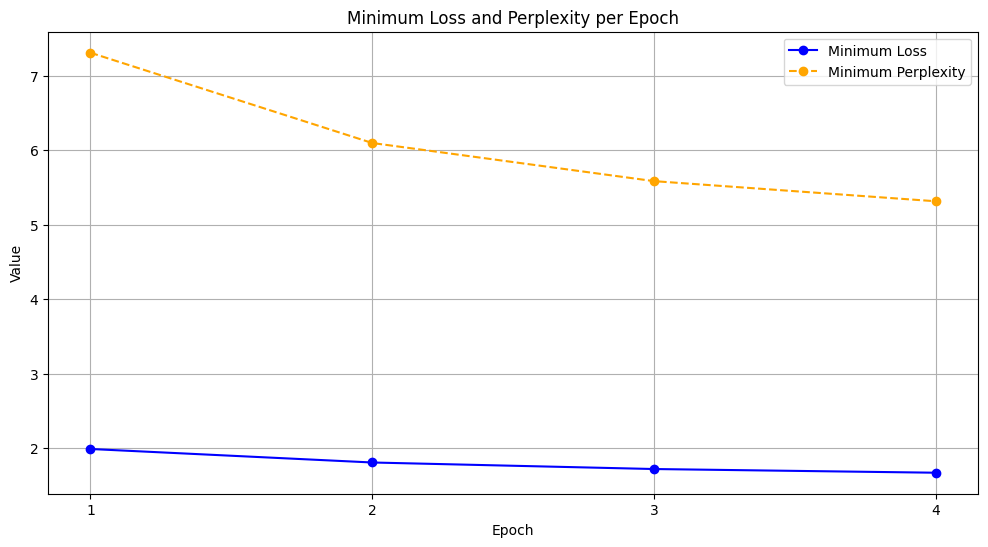

In [58]:
import matplotlib.pyplot as plt

file_path = '/content/training_log.txt'
epoch_metrics = {}

with open(file_path, 'r') as file:
    for line in file:
        if "Epoch" in line and "Step" in line and "Loss" in line:
            parts = line.split(",")
            epoch = int(parts[0].split("[")[1].split("/")[0])  # Extract Epoch value
            loss = float(parts[2].split(":")[1])  # Extract Loss value
            perplexity = (parts[3].split(":")[1])
            perplexity = float(perplexity.replace('\\', ''))

            # Store metrics in a dictionary, grouped by epoch
            if epoch not in epoch_metrics:
                epoch_metrics[epoch] = {'loss': [], 'perplexity': []}
            epoch_metrics[epoch]['loss'].append(loss)
            epoch_metrics[epoch]['perplexity'].append(perplexity)

# minimum metrics for each epoch
epochs = sorted(epoch_metrics.keys())  # sorted epochs
min_losses = [min(epoch_metrics[epoch]['loss']) for epoch in epochs]
min_perplexities = [min(epoch_metrics[epoch]['perplexity']) for epoch in epochs]
plt.figure(figsize=(12, 6))

# Plot for Loss
plt.plot(epochs, min_losses, label='Minimum Loss', marker='o', linestyle='-', color='blue')

# Plot for Perplexity
plt.plot(epochs, min_perplexities, label='Minimum Perplexity', marker='o', linestyle='--', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Minimum Loss and Perplexity per Epoch')
plt.grid(True)
plt.xticks(epochs)
plt.legend()
plt.show()

## **VALIDATING**


In [40]:
transform_test = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
            (0.229, 0.224, 0.225),
        ),
    ]
)

#Create the data loader.
val_data_loader = get_loader(
    transform=transform_test, mode="valid", cocoapi_loc=cocoapi_dir
)


encoder_file = "encoder-4.pkl"
decoder_file = "decoder-4.pkl"

# Initialize the encoder and decoder.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Moving models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Loading the trained weights
# encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file)))
# decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file)))

encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file), map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file), map_location=torch.device('cpu')))


encoder.eval()
decoder.eval()

Vocabulary successfully loaded from vocab.pkl file!


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-40-c9674c54453d>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

DecoderRNN(
  (embed): Embedding(10321, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=10321, bias=True)
)

In [41]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu_score(true_sentences, predicted_captions):
    # true_sentences: Dictionary mapping image IDs to lists of true captions.
    # predicted_captions: Dictionary mapping image IDs to lists of predicted captions.

    hypotheses = []
    references = []

    # Process captions for common image IDs between references and predictions.
    for img_id in set(true_sentences.keys()).intersection(predicted_captions.keys()):
        true_captions = [caption.split() for caption in true_sentences[img_id]]
        references.append(true_captions)

        # Use the first predicted caption for evaluation.
        predicted_caption = predicted_captions[img_id][0].strip().split()
        hypotheses.append(predicted_caption)

    # Calculate and return the BLEU score.
    return corpus_bleu(references, hypotheses)

def clean_sentence(output, idx2word):
  # output -> ids of the words, forming a sentence

  clean_sentencee = ""
  for index in output:
      word = idx2word[index]
      if index == 0:  # Skip the <start> token.
          continue
      if index == 1:  # Stop processing when <end> token is encountered.
          break
      if index == 18:  # Handle special case for specific word index.
          clean_sentencee += word
      else:
          clean_sentencee += " " + word
  return clean_sentencee

In [42]:
# infer captions for all images
pred_result = defaultdict(list)

for img_id, img in tqdm(val_data_loader):
    img = img.to(device)
    with torch.no_grad():
        features = encoder(img).unsqueeze(1)
        output = decoder.sample(features)

    sentence = clean_sentence(output, val_data_loader.dataset.vocab.idx2word)

    pred_result[img_id.item()].append(sentence)

100%|██████████| 5000/5000 [01:36<00:00, 51.62it/s]


In [43]:
with open(
    os.path.join(cocoapi_dir, "/content/cocoapi/annotations/annotations/captions_val2017.json"), "r"
) as f:
    caption = json.load(f)

valid_annot = caption["annotations"]
valid_result = defaultdict(list)
for i in valid_annot:
    valid_result[i["image_id"]].append(i["caption"].lower())

In [38]:
# Some valid data set captions:

print(list(valid_result)[:3])
list(valid_result.values())[:3]

[179765, 190236, 331352]


[['a black honda motorcycle parked in front of a garage.',
  'a honda motorcycle parked in a grass driveway',
  'a black honda motorcycle with a dark burgundy seat.',
  'ma motorcycle parked on the gravel in front of a garage',
  'a motorcycle with its brake extended standing outside'],
 ['an office cubicle with four different types of computers.',
  'the home office space seems to be very cluttered.',
  'an office with desk computer and chair and laptop.',
  'office setting with a lot of computer screens.',
  'a desk and chair in an office cubicle.'],
 ['a small closed toilet in a cramped space.',
  'a tan toilet and sink combination in a small room.',
  'this is an advanced toilet with a sink and control panel.',
  'a close-up picture of a toilet with a fountain.',
  'off white toilet with a faucet and controls. ']]

### **BLEU SCORE**

In [44]:
calculate_bleu_score(true_sentences=valid_result, predicted_captions=pred_result)

0.19892040541833822

In [39]:
print(list(pred_result)[:3])
list(pred_result.values())[:3]

[98520, 194940, 570834]


[[' a large air plane on a run way'],
 [' a plate of food with a sandwich and a bowl of soup .'],
 [' a man is walking down the street in the rain']]

## **TESTING ON DIFF IMAGES**

In [ ]:
# Get testing data annotations
!wget http://images.cocodataset.org/annotations/image_info_test2017.zip

# Unzip into a specific folder
!mkdir -p /content/cocoapi/annotations  # Create a folder for annotations
!unzip -q image_info_test2017.zip -d /content/cocoapi/annotations  # Extract annotations


--2025-01-07 19:43:17--  http://images.cocodataset.org/annotations/image_info_test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.221.169, 52.216.49.137, 3.5.27.212, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.221.169|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1144034 (1.1M) [application/zip]
Saving to: ‘image_info_test2017.zip’

image_info_test2017 100%[===================>]   1.09M   851KB/s    in 1.3s    

2025-01-07 19:43:19 (851 KB/s) - ‘image_info_test2017.zip’ saved [1144034/1144034]



In [ ]:
# Download testing images (train2017.zip)
!wget http://images.cocodataset.org/zips/test2017.zip

# Unzip into a specific folder
!mkdir -p /content/cocoapi/images  # Create a folder for testing images
!unzip -q test2017.zip -d /content/cocoapi/images  # Extract images

--2025-01-07 19:43:35--  http://images.cocodataset.org/zips/test2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.176.27, 3.5.25.60, 3.5.22.221, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.176.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6646970404 (6.2G) [application/zip]
Saving to: ‘test2017.zip’

test2017.zip        100%[===================>]   6.19G  13.6MB/s    in 6m 25s  

2025-01-07 19:50:01 (16.5 MB/s) - ‘test2017.zip’ saved [6646970404/6646970404]



### **Testing a particular Image with epoch-1 vs epoch-4 model :**

<ipython-input-50-a9d9730c4d28>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file)))
<ipython-input-

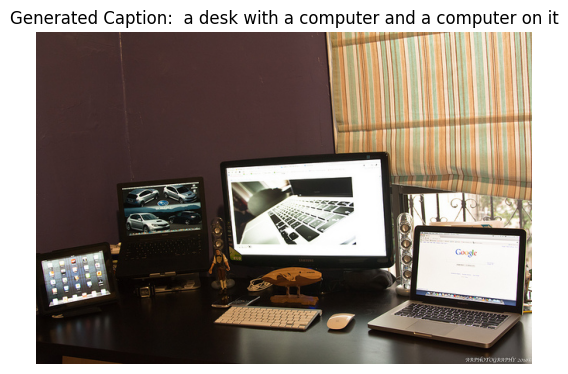

In [ ]:
from PIL import Image
import torch
from torchvision import transforms
import os
import pickle
import matplotlib.pyplot as plt

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the necessary parameters
embed_size = 256  # Assuming it's the same as during training
hidden_size = 512  # Assuming it's the same as during training
vocab_file = "vocab.pkl"  # Assuming the name of the vocabulary file

# Load the vocabulary
with open(os.path.join("/content/", vocab_file), "rb") as f:
    vocab = pickle.load(f)

vocab_size = len(vocab)

# Initialize the encoder and decoder.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Moving models to the appropriate device
encoder.to(device)
decoder.to(device)

####### Load the trained weights of 1st epoch model
encoder_file = "encoder-1.pkl"
decoder_file = "decoder-1.pkl"

encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file)))
decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file)))

# encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file), map_location=torch.device('cpu')))
# decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file), map_location=torch.device('cpu')))

# Set models to evaluation mode
encoder.eval()
decoder.eval()

# Load the test image
test_image_path = "/content/cocoapi/images/test2017/000000000509.jpg"  # Replace with the path to your test image
test_image = Image.open(test_image_path).convert("RGB")

# Apply transformations to the test image
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Preprocess the test image
test_image = transform_test(test_image).unsqueeze(0)  # Add batch dimension

# Move the preprocessed image to the appropriate device
test_image = test_image.to(device)

# Pass the test image through the encoder
with torch.no_grad():
    features = encoder(test_image).unsqueeze(1)

# Generate captions with the decoder
with torch.no_grad():
    output = decoder.sample(features)

# Convert the output into a clean sentence
caption = clean_sentence(output, vocab.idx2word)

# Display the test image with the generated caption
plt.imshow(Image.open(test_image_path))
plt.axis('off')
plt.title('Generated Caption: ' + caption)
plt.show()

<ipython-input-51-fe84d8218468>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file)))
<ipython-input-

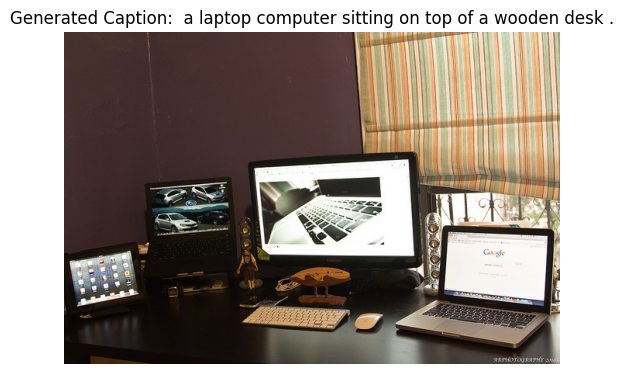

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the encoder and decoder.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Moving models to the appropriate device
encoder.to(device)
decoder.to(device)

####### Load the trained weights of 4th epoch model
encoder_file = "encoder-4.pkl"
decoder_file = "decoder-4.pkl"

encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file)))
decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file)))

# encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file), map_location=torch.device('cpu')))
# decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file), map_location=torch.device('cpu')))

# Set models to evaluation mode
encoder.eval()
decoder.eval()

# Load the test image
test_image_path = "/content/cocoapi/images/test2017/000000000509.jpg" # Replace with the path to your test image
test_image = Image.open(test_image_path).convert("RGB")

# Apply transformations to the test image
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Preprocess the test image
test_image = transform_test(test_image).unsqueeze(0)  # Add batch dimension

# Move the preprocessed image to the appropriate device
test_image = test_image.to(device)

# Pass the test image through the encoder
with torch.no_grad():
    features = encoder(test_image).unsqueeze(1)

# Generate captions with the decoder
with torch.no_grad():
    output = decoder.sample(features)

# Convert the output into a clean sentence
caption = clean_sentence(output, vocab.idx2word)

# Display the test image with the generated caption
plt.imshow(Image.open(test_image_path))
plt.axis('off')
plt.title('Generated Caption: ' + caption)
plt.show()

### **Example of a Bad result on epoch-4 model:**

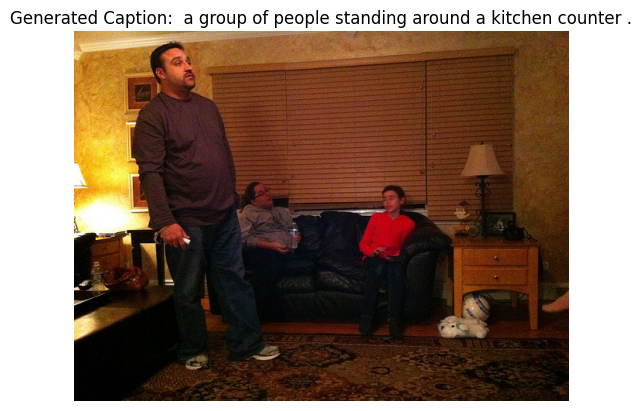

In [ ]:
# Load the test image
test_image_path = "/content/cocoapi/images/test2017/000000000456.jpg"  # Replace with the path to your test image
test_image = Image.open(test_image_path).convert("RGB")

# Apply transformations to the test image
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Preprocess the test image
test_image = transform_test(test_image).unsqueeze(0)  # Add batch dimension

# Move the preprocessed image to the appropriate device
test_image = test_image.to(device)

# Pass the test image through the encoder
with torch.no_grad():
    features = encoder(test_image).unsqueeze(1)

# Generate captions with the decoder
with torch.no_grad():
    output = decoder.sample(features)

# Convert the output into a clean sentence
caption = clean_sentence(output, vocab.idx2word)

# Display the test image with the generated caption
plt.imshow(Image.open(test_image_path))
plt.axis('off')
plt.title('Generated Caption: ' + caption)
plt.show()

### **Randomly picked Images being tested on epoch-4 model:**

/content/cocoapi/images/test2017/000000451199.jpg


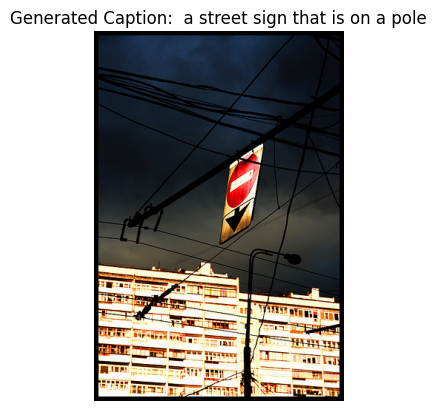

/content/cocoapi/images/test2017/000000182479.jpg


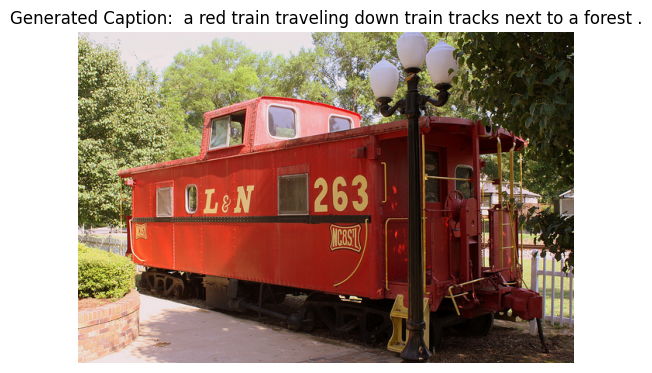

/content/cocoapi/images/test2017/000000004505.jpg


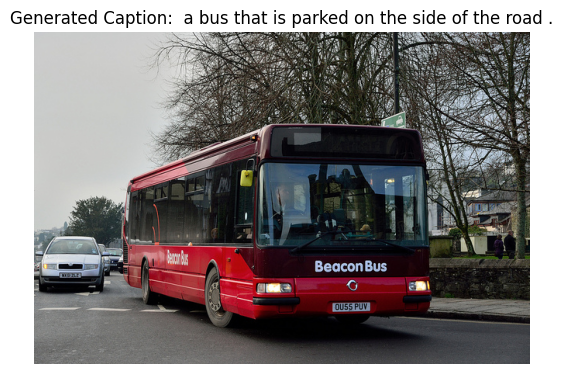

/content/cocoapi/images/test2017/000000082314.jpg


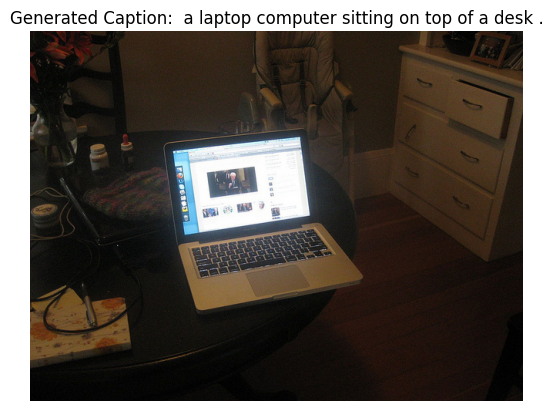

/content/cocoapi/images/test2017/000000436543.jpg


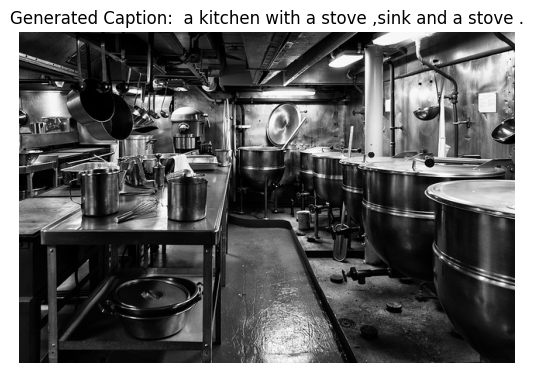

/content/cocoapi/images/test2017/000000157842.jpg


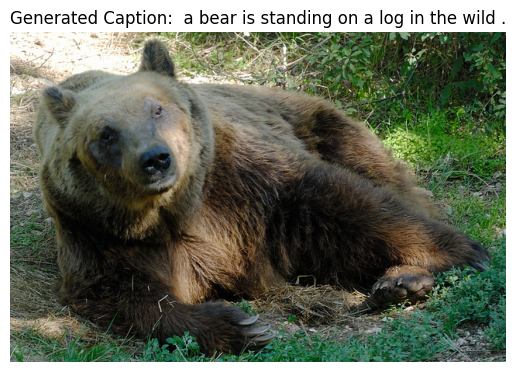

/content/cocoapi/images/test2017/000000335646.jpg


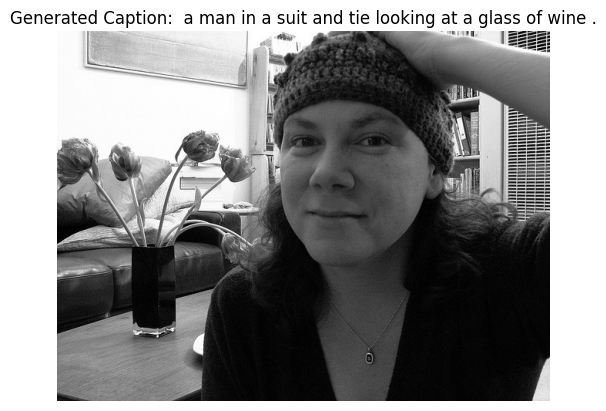

/content/cocoapi/images/test2017/000000561877.jpg


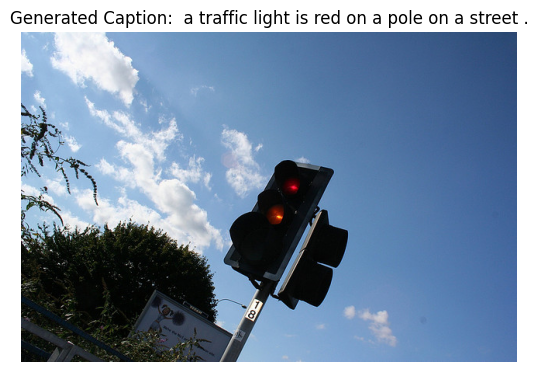

/content/cocoapi/images/test2017/000000389991.jpg


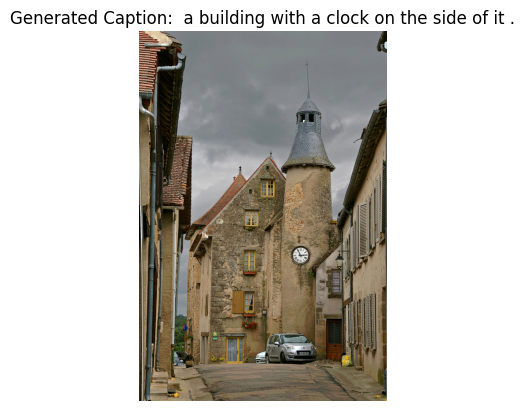

/content/cocoapi/images/test2017/000000545504.jpg


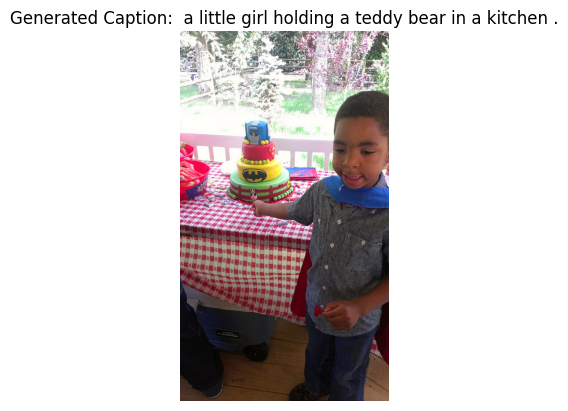

In [ ]:
import random
# Path to the test2017 folder
test_image_dir = "/content/cocoapi/images/test2017"

# Get all image paths in the directory
image_paths = [os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith('.jpg')]


# Randomly select 10 images
random_image_paths = random.sample(image_paths, 10)

# Define the transformation for the test image
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Loop through the random images
for img_path in random_image_paths:
    print(img_path)
    # Open and preprocess the image
    test_image = Image.open(img_path).convert("RGB")
    test_image = transform_test(test_image).unsqueeze(0)  # Add batch dimension

    # Move the preprocessed image to the appropriate device
    test_image = test_image.to(device)

    # Pass the test image through the encoder
    with torch.no_grad():
        features = encoder(test_image).unsqueeze(1)

    # Generate captions with the decoder
    with torch.no_grad():
        output = decoder.sample(features)

    # Convert the output into a clean sentence
    caption = clean_sentence(output, vocab.idx2word)

    # Display the image with the generated caption
    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.title('Generated Caption: ' + caption)
    plt.show()